In [2]:
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
# vector store 생성
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

vector_store = Chroma(
    collection_name="income_tax_collection",
    persist_directory="./income_tax_collection",
    embedding_function=embeddings
)

retriver = vector_store.as_retriever(search_kwargs={"k": 3})

In [4]:
# llm 설정
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

In [12]:
# StateGraph
from typing_extensions import TypedDict
from langchain_core.documents import Document

class AgentState(TypedDict):
    question: str
    answer: str
    context: list

In [16]:
# graph builder
from langgraph.graph import StateGraph

graph_builder = StateGraph(AgentState)

In [7]:
# retriver node
def retrive(state: AgentState) -> AgentState:
    question = state["question"]
    docs = retriver.invoke(question)
    return {"context": docs}

In [ ]:
from langchain_classic import hub
from langchain_core.output_parsers import StrOutputParser

generate_prompt = hub.pull("rlm/rag-prompt")

def generate(state: AgentState) -> AgentState:
    content = state["context"]
    question = state["question"]
    rag_chain = generate_prompt | llm | StrOutputParser()
    answer = rag_chain.invoke({"context": content, "question": question})

    print(f"answer: {answer}")
    return {"answer": answer}

In [9]:
# chekc docs node
from langchain_classic import hub
from typing import Literal

doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")

def relevance_doc(state: AgentState) -> Literal['relevant', 'irrelevant']:
    question = state["question"]
    context = state["context"]
    doc_relevance_chain = doc_relevance_prompt | llm
    relevance = doc_relevance_chain.invoke({"question": question, "documents": context})

    print(f"context: {context}")
    print(f"relevance: {relevance}")

    if relevance['Score'] == 1:
        return 'relevant'
    
    return 'irrelevant'


In [10]:
# rewrite node
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

rewrite_prompt = PromptTemplate.from_template(f"""사용자의 질문을 보고, 웹 검색에 용의하게 사용자의 질문을 변경해주세요
질문: {{question}}
""")

def rewrite(state: AgentState):
    question = state["question"]
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()
    rewritten_question = rewrite_chain.invoke({"question": question})

    print(f"rewritten_question: {rewritten_question}")
    return {"question": rewritten_question}

In [14]:
from langchain_community.tools import TavilySearchResults

tavliy_search_tool = TavilySearchResults(
    max_results=3,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
)

def web_search(state: AgentState) :
    question = state["question"]
    search_tool = tavliy_search_tool.as_tool()
    result = search_tool.invoke({"query": question})

    print(f"result: {result}")
    return {"context": result}


/var/folders/z1/kkrl3fn92r95z4l05sfrl4x40000gn/T/ipykernel_17863/2679622819.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavliy_search_tool = TavilySearchResults(


In [17]:
graph_builder.add_node("retrive", retrive)
graph_builder.add_node("generate", generate)
graph_builder.add_node("rewrite", rewrite)
graph_builder.add_node("web_search", web_search)

In [18]:
from langgraph.graph import START, END

graph_builder.add_edge(START, "retrive")
graph_builder.add_conditional_edges(
    "retrive",
    relevance_doc,
    {
        "relevant": "generate",
        "irrelevant": "rewrite"
    }
)

graph_builder.add_edge("rewrite", "web_search")
graph_builder.add_edge("web_search", "generate")
graph_builder.add_edge("generate", END)


In [19]:
graph = graph_builder.compile()

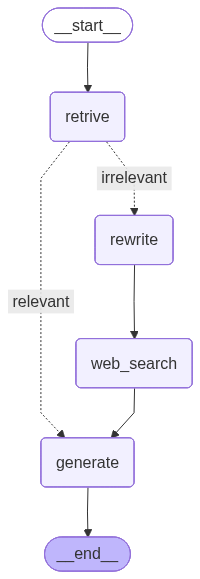

In [20]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
question = "연봉 5천만원 거주자의 소득세는 얼마인가요?"
initial_state = {"question": question}

graph.invoke(initial_state)